In [1]:
import sys
import os
sys.path.append("..")

In [2]:
from collections import defaultdict
import os
import gzip
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import pyplot as plt
from colour import Color

from shapely.geometry.polygon import Polygon
from descartes import PolygonPatch
from diachr.diachromatic_interaction_set import DiachromaticInteractionSet
from diachr.diachromatic_interaction import DiachromaticInteraction

In [3]:
class Digest:
    """
    Represent a BED3 version of a digest
    """

    def __init__(self, chrom, begin, end):
        if not isinstance(chrom, str):
            raise ValueError("chrom must be string")
        if not isinstance(begin, int) and isinstance(end, int):
            raise ValueError("begin and end must be ints")
        self._chrom = chrom
        self._begin = begin
        self._end = end

    @property
    def chrom(self):
        return self._chrom

    @property
    def begin(self):
        return self._begin

    @property
    def end(self):
        return self._end

    def __repr__(self):
        return "Digest(%s:%d-%d)" % (self._chrom, self._begin, self._end)

    def __eq__(self, other):
        if isinstance(other, Digest):
            return ((self._chrom == other._chrom) and (self._begin == other._begin) and (self._end == other._end))
        else:
            return False

    def __ne__(self, other):
        return (not self.__eq__(other))

    def __hash__(self):
        return hash(self.__repr__())

In [4]:
class Interaction:
    def __init__(self, digestA, digestB, statusA, statusB, ST, icat) -> None:
        if not (isinstance(digestA, Digest) and isinstance(digestB, Digest)):
            raise ValueError("Did not pass Digest object")
        if statusA != 'E' and statusA != 'N':
            raise ValueError("Invalid status A")
        if statusB != 'E' and statusB != 'N':
            raise ValueError("Invalid status B")
        if ':' not in ST:
            raise ValueError("Invalid ST String")
        valid_icat = {'DIX','DI', 'UIR', 'UI'}
        if icat not in valid_icat:
            raise ValueError("Invalid interaction. category: {}".format(icat))
        fields = ST.split(":")
        if len(fields) != 4:
            raise ValueError("Invalid ST String (We got {})".format(ST))
        self._digestA = digestA
        self._digestB = digestB
        self._statusA = statusA
        self._statusB = statusB
        self._simple = int(fields[0]) + int(fields[1])
        self._twisted = int(fields[2]) + int(fields[3])
        self._icat = icat
        self._min = None
        self._max = None
        self._span = None
        self._factor = None

    @property
    def digestA(self):
        return self._digestA

    @property
    def digestB(self):
        return self._digestB

    @property
    def simple(self):
        return self._simple

    @property
    def twisted(self):
        return self._twisted
    
    @property
    def icat(self):
        return self._icat

    @property
    def percentage(self):
        p = int(100 * self._simple / (self._simple + self._twisted))
        if p > 99:
            return 99
        else:
            return p


In [60]:
class DirectedTadVisualizer:
    """
    This class coorrdinates the visualization of TADs, while showing directedness of interactions
    within each cell.
    """

    def __init__(self, fname) -> None:
        if not isinstance(fname, str) or not os.path.isfile(fname):
            raise ValueError("Invalid directed interaction file {}".format(fname))
        self._fname = fname
        self._figure_size = 10
        c1 = '#1f77b4'  # blue
        c2 = 'green'  # green
        red = Color("red")
        self._colors = list(red.range_to(Color(c1), 100))

    def extract_interactions(self, chrom, begin, end, fname='dtadvis-out.tsv'):
        if not isinstance(chrom, str):
            raise ValueError("chrom must be a string")
        if not isinstance(begin, int) or not isinstance(end, int):
            raise ValueError("begin and end must be integers")
        interaction_set = DiachromaticInteractionSet()
        inter_dict = defaultdict(DiachromaticInteraction)
        LEN = len(chrom)
        if self._fname.endswith(".gz"):
            with gzip.open(self._fname, 'rt') as fp:
                n_lines = 0
                for line in fp:
                    n_lines += 1
                    if n_lines % 1000000 == 0:
                        print("\t[INFO] Parsed " + "{:,}".format(n_lines) + " interaction lines ...")
                    #if line[:LEN] != chrom:
                        #continue  # skip lines from other chromosomes
                    d_inter = interaction_set._parse_line(line)
                    # Only keep interactions completely within the region we want to visualize
                    #if d_inter.chrA == chrom and d_inter.chrB == chrom:
                        #if d_inter.fromA < begin or d_inter.toA > end or d_inter.fromB < begin or d_inter.toB > end:
                            #continue
                    
                    # Skip trans interactions
                    if d_inter.chrA != d_inter.chrB:
                        continue

                    # Only keep interactions completely within the region we want to visualize
                    if d_inter.chrA != chrom or d_inter.fromA < begin or end < d_inter.toB:
                        continue
                            
                    if d_inter.key in inter_dict:
                        inter_dict[d_inter.key].append_interaction_data(simple=d_inter.n_simple,
                                                                        twisted=d_inter.n_twisted)
                    else:
                        inter_dict[d_inter.key] = d_inter
        else:
            raise ValueError("Only gzip files supported")
        print("[INFO] Extracted {} interactions in range {}:{}-{}".format(len(inter_dict), chrom, begin, end))
        with open(fname, 'wt') as fh:
            for ia in inter_dict.values():
                fh.write(ia.get_diachromatic_interaction_line() + "\n")
        fh.close()

    def pos_to_coordinate(self, pos):
        return (pos - self._min) * self._factor

    def digest_to_coordinates(self, digest):
        begin = self.pos_to_coordinate(digest.begin) 
        end = self.pos_to_coordinate(digest.end)
        return [begin, end]

    def interaction_to_polygon(self, interaction, digest_to_coords):
        if not isinstance(interaction, Interaction):
            raise ValueError("Not an Interaction")
        if not isinstance(digest_to_coords, dict):
            raise ValueError("Not a dictionary")
        
        TANGENT_45 = math.tan(math.pi / 4)  # The lines go up at 45 degree angles
        # a,b,c,d are coordinates of the two digests on the X axis
        a = self.pos_to_coordinate(interaction.digestA.begin)
        b = self.pos_to_coordinate(interaction.digestA.end)
        c = self.pos_to_coordinate(interaction.digestB.begin)
        d = self.pos_to_coordinate(interaction.digestB.end)
        # bc is the point where lines from b and c meet
        bc_x = b + 0.5 * (c - b)
        # bc is the length of the segment from b to bc_x
        bc = bc_x - b
        # tan = opposite/adjacent
        # opposite = tan(45)*adjacent
        bc_y = TANGENT_45 * bc
        # ad is the point where lines from a and d meet
        ad_x = a + 0.5 * (d - a)
        ad = ad_x - a
        ad_y = TANGENT_45 * ad
        # ac is the point where lines from a and c meet
        ac_x = a + 0.5 * (c - a)
        ac = ac_x - a
        ac_y = TANGENT_45 * ac
        # bd is the point where lines from b and d meet
        bd_x = b + 0.5 * (d - b)
        bd = bd_x - b
        bd_y = TANGENT_45 * bd
        poly = Polygon([(bc_x, bc_y), (bd_x, bd_y), (ad_x, ad_y), (ac_x, ac_y)])
        icat = interaction.icat
        color = 'orangered' # default, for DIX
        if icat == 'DI':
            color = 'orange'
        elif icat == 'UIR':
            color = 'lightblue'
        else:
            color = 'gray'
        i = interaction.percentage
        #color = self._colors[i].get_rgb()
        return PolygonPatch(polygon=poly, ec=color)

    def create_visualization(self, fname):
        """
        chr4	10154260	10155805	N	chr4	10361332	10367100	N	1:1
        """
        if not isinstance(fname, str) or not os.path.isfile(fname):
            raise ValueError("Invalid directed interaction file {}".format(fname))
        digest_set = set()
        interaction_list = []
        with open(fname) as f:
            for line in f:
                fields = line.rstrip().split('\t')
                digestA = Digest(chrom=fields[0], begin=int(fields[1]), end=int(fields[2]))
                digestB = Digest(chrom=fields[4], begin=int(fields[5]), end=int(fields[6]))
                digest_set.add(digestA)
                digest_set.add(digestB)
                statusA = fields[3] # N or E for digest A
                statusB = fields[7] # N or E for digest B
                ST = fields[8] # e.g., 2:3:1:5, read pair counts
                icat = fields[10] # interaction category, e.g. DIX, DI, etc.
                ia = Interaction(digestA=digestA, digestB=digestB, statusA=statusA, statusB=statusB, ST=ST, icat=icat)
                interaction_list.append(ia)

        digest_list = list(digest_set)
        digest_list.sort(key=lambda x: x.begin, reverse=False)
        self._min = min([x.begin for x in digest_list])
        self._max = max([x.end for x in digest_list])
        self._span = self._max - self._min
        self._factor = self._figure_size / self._span
        print("[INFO] min: {} max: {}".format(self._min, self._max))
        digest_to_coords = defaultdict(list)
        for d in digest_list:
            digest_to_coords[d] = self.digest_to_coordinates(d)
        print("[INFO] Got {} digests".format(len(digest_set)))
        print("[INFO] Got {} interactions".format(len(interaction_list)))
        fig = plt.figure(1, figsize=(10, 10))
        ax = fig.add_subplot(111)

        ax.set_title('Directed Interactions')
        xrange = [0, 10]
        yrange = [0, 10]
        ax.set_xlim(xrange)
        ax.set_ylim(yrange)
        for ia in interaction_list:
            polypatch = self.interaction_to_polygon(interaction=ia, digest_to_coords=digest_to_coords)
            ax.add_patch(polypatch)
        # ax.set_xticks(range(*xrange) + [xrange[-1]])
        # ax.set_ylim(*yrange)
        # ax.set_yticks(range(*yrange) + [yrange[-1]])
        ax.set_aspect(1)
        plt.show()


In [6]:
infile = '/Users/robinp/Downloads/JAV_MK_RALT_20000_ht_fdr0.05_evaluated_and_categorized_interactions.tsv.gz'

In [31]:
infile = '/Users/hansep/PycharmProjects/diachrscripts/DICer_interactions/HT/FDR005/CHC/JAV_MK_RALT_20000_ht_fdr0.05_evaluated_and_categorized_interactions_chr10.tsv.gz'

In [61]:
chrom = 'chr10'
begin = 95500000
end = begin + 500000

[INFO] Extracted 797 interactions in range chr10:95500000-96000000
[INFO] min: 95504767 max: 95996356
[INFO] Got 148 digests
[INFO] Got 797 interactions


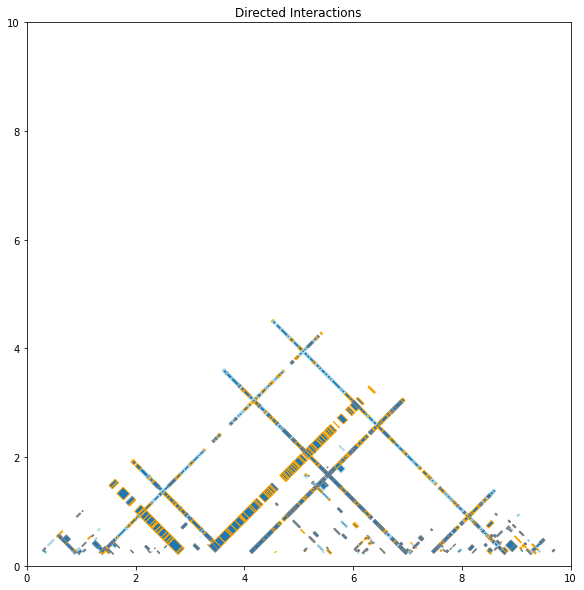

In [62]:
visualizer = DirectedTadVisualizer(fname=infile)
outname = 'dtadvis-out.tsv'
visualizer.extract_interactions(chrom=chrom, begin=begin, end=end, fname=outname)
visualizer.create_visualization(outname)
